# 0. Google Colab Setups

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
os.chdir('./drive/MyDrive/NLP MedLM project')

In [3]:
!pip install transformers

In [4]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00


In [5]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [6]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [21]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 2.8 MB/s eta 0:00:00


In [29]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=1ec328c7ce5d8e7139ab5c5badcc97df585bf2a852066ad91d0adaf0aa08642b
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


# 1. Preprocessing iCliniq
+ Question and Anaswers needs to be combined to QA pairs for fine-tuning.
+ Only Question is needed for the testing data.
+ For training set data: Add [question] beofore each question text, and add[answer] before each answer text. For test set data: Add [question] before each question text and add [answer] to the end of the question.

In [9]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
from transformers import BloomTokenizerFast, BloomForCausalLM, pipeline
from datasets import DatasetDict, Dataset
from transformers import Trainer, TrainingArguments
import evaluate

from tqdm import tqdm
import ast


In [10]:
# load MedQuAD train and test dataset
train_df = pd.read_csv('./dataset/iCliniq_train.csv')
test_df = pd.read_csv('./dataset/iCliniq_test.csv')

In [11]:
# add special tokens
# adding prompting tokens before each question and answer
def prepend_q(row):
  return '[question] ' + str(row)

def prepend_a(row):
  return '\n [answer] ' + str(row)

def prepend_qa(row):
  return '[question] ' + str(row) + '\n [answer]'

train_df['Question'] = train_df['Question'].apply(prepend_q)
train_df['Answer_cut'] = train_df['Answer_cut'].apply(prepend_a)
#combine question and answer
train_df['QA'] = train_df['Question'].str.cat(train_df['Answer_cut'], sep = '')

test_df['Question'] = test_df['Question'].apply(prepend_qa)

In [12]:
# check data
train_df.head(1)

,Question,Answer,Answer_cut,QA
0,[question] blood while pooping help please. i'...,bright red blood during defecation is most lik...,\n [answer] bright red blood during defecation...,[question] blood while pooping help please. i'...


In [13]:
test_df.head(1)

,Question,Answer,Answer_cut
0,[question] is steph infacon contages\n [answer],yes staphylococcal (staph) infections are cont...,yes staphylococcal (staph) infections are cont...


In [14]:
# split part of the data for evaluation
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=123)

In [15]:
print(len(train_df))
print(len(val_df))

19040
4761


In [16]:
# form dataset with hf datasets
train = {
    "text" : train_df['QA']
}
test = {
    "text": val_df['QA']
}

train_dataset = Dataset.from_dict(train)
test_dataset = Dataset.from_dict(test)

datasets = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# 2. Tokenization
+ Use tokenizer designed for BLOOM

In [ ]:
MODEL_TYPE = "bigscience/bloom-560m"
MAX_LENGTH = 300

tokenizer = BloomTokenizerFast.from_pretrained(MODEL_TYPE)
model = BloomForCausalLM.from_pretrained(MODEL_TYPE)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

cuda:0


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=MAX_LENGTH)

In [ ]:
# need to delete the original text column
tokenized_dataset = datasets.map(tokenize_function, batched=True, num_proc=8, remove_columns=["text"])

Map (num_proc=8):   0%|          | 0/19040 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/4761 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 19040
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 4761
    })
})

In [ ]:
block_size = MAX_LENGTH
def group_texts(examples):
  # Concatenate all texts.
  # examples = {k: sum(examples[k], []) for k in examples.keys()}
  #   total_length = len(concatenated_examples[list(examples.keys())[0]])
  #   # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
  #       # customize this part to your needs.
  #   total_length = (total_length // block_size) * block_size
  #   # Split by chunks of max_len.
  #   result = {
	# k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
  #       for k, t in concatenated_examples.items()
  #   }
  examples["labels"] = examples["input_ids"].copy()
  return examples

In [ ]:
lm_datasets = tokenized_dataset.map(
    group_texts,
    batched=True,
    batch_size=100,
    num_proc=8,
)

Map (num_proc=8):   0%|          | 0/19040 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/4761 [00:00<?, ? examples/s]

# 3. Fine-Tuning
+ From research, we learned that the learning rate during finetuning partly depends on the size of the dataset, when the dataset is small, it is better to use smaller learning rate.

In [ ]:
training_args = TrainingArguments(
    f"bloom-finetuned-icliniq",
    num_train_epochs= 2, # 3 epoch is not practical
    per_device_train_batch_size= 2,
    gradient_checkpointing= True,
    gradient_accumulation_steps= 5,
    optim= "adafactor",
    logging_steps= 50,
    save_strategy= 'epoch',
    weight_decay= 0.1,
    learning_rate= 5e-6,
    evaluation_strategy= 'steps',
    eval_steps= 200,
    per_device_eval_batch_size= 2,
    warmup_ratio = 0.01 # epoch * 1%
)

trainer = Trainer(
    model= model,
    args= training_args,
    train_dataset= lm_datasets["train"],
    eval_dataset= lm_datasets["test"],
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differe

Step,Training Loss,Validation Loss
200,1.478700,1.448980
400,1.494000,1.403148
600,1.370100,1.385536
800,1.410600,1.370285
1000,1.315900,1.359265
1200,1.369000,1.350014
1400,1.422600,1.340610
1600,1.374800,1.333672
1800,1.274800,1.328576
2000,1.293100,1.326148


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=3808, training_loss=1.4515579721006024, metrics={'train_runtime': 26979.5731, 'train_samples_per_second': 1.411, 'train_steps_per_second': 0.141, 'total_flos': 2.0721774624768e+16, 'train_loss': 1.4515579721006024, 'epoch': 2.0})

In [ ]:
trainer.state.log_history

In [ ]:
train_log = pd.DataFrame(trainer.state.log_history)
train_log.to_csv("./bloom-finetuned-icliniq/train_log.csv", index = False)

<Axes: >

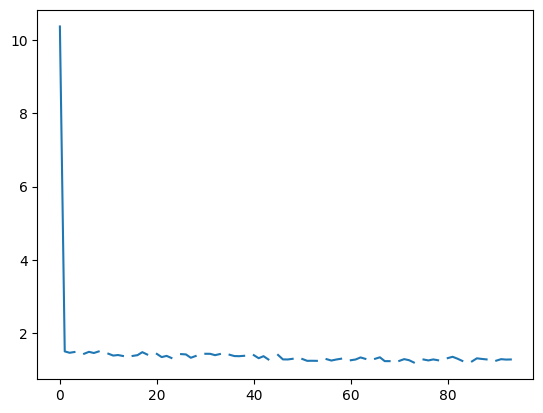

In [ ]:
# plot the training and validation loss
train_log['loss'].plot()

# 4. Inference
+ Use the finetuned model to perform inference on the test set

In [16]:
MODEL_TYPE = "bigscience/bloom-560m"
tokenizer = BloomTokenizerFast.from_pretrained(MODEL_TYPE)
model = BloomForCausalLM.from_pretrained("./bloom-finetuned-icliniq/checkpoint-3808")
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250880, 1024)
    (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-23): 24 x BloomBlock(
        (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear(in_features=1024, out_features=3072, bias=True)
          (dense): Linear(in_features=1024, out_features=1024, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear(in_features=1024, out_features=4096, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = pipeline('text-generation', model=model.to(device), device = 0, tokenizer=tokenizer, do_sample=False)

In [18]:
# test questions as list
test_data = test_df['Question'].tolist()

In [19]:

# Divide the list into sublists
print(len(test_data))
sublists = [test_data[i:i+32] for i in range(0, len(test_data), 32)]
print(len(sublists))


5951
186


In [20]:
# inference on all data
# test different batchsize to find the best suitable one
gen_ans_lists = []
for sub_test_data in tqdm(sublists):
  with torch.no_grad():
    gen_ans = generator(sub_test_data, max_new_tokens=300, batch_size=32 )
    gen_ans_lists.append(gen_ans)

  5%|▌         | 10/186 [01:08<19:24,  6.61s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 186/186 [20:30<00:00,  6.61s/it]


In [21]:
# store the temporary generated answers
len(gen_ans_lists)
gen_ans_df = pd.DataFrame(gen_ans_lists)
gen_ans_df.to_csv("iCliniq_gen_ans.csv", index = False)

# 5. Evaluation

In [22]:
# load the generated answers
gen_ans_df = pd.read_csv("iCliniq_gen_ans.csv")
gen_ans_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,[{'generated_text': '[question] is steph infac...,[{'generated_text': '[question] how do i care ...,[{'generated_text': '[question] how is high bl...,[{'generated_text': '[question] hello im a 27 ...,[{'generated_text': '[question] trying to get ...,[{'generated_text': '[question] how soon is it...,"[{'generated_text': ""[question] what doctor to...",[{'generated_text': '[question] how should you...,"[{'generated_text': ""[question] weird bump on ...",[{'generated_text': '[question] how is a catar...,...,[{'generated_text': '[question] i stopped taki...,[{'generated_text': '[question] i fainted hit ...,[{'generated_text': '[question] i go into peri...,"[{'generated_text': ""[question] i had sex 11 y...",[{'generated_text': '[question] compare pallia...,[{'generated_text': '[question] can having var...,[{'generated_text': '[question] small red whel...,[{'generated_text': '[question] what is the re...,[{'generated_text': '[question] i was told i h...,"[{'generated_text': ""[question] i ate an under..."
1,[{'generated_text': '[question] i have vomited...,"[{'generated_text': ""[question] what to eat wi...",[{'generated_text': '[question] how do i get m...,[{'generated_text': '[question] doctor could y...,[{'generated_text': '[question] can prostatiti...,[{'generated_text': '[question] i have been in...,[{'generated_text': '[question] i was hospital...,[{'generated_text': '[question] how are female...,[{'generated_text': '[question] can miralax ca...,[{'generated_text': '[question] are there any ...,...,[{'generated_text': '[question] had nasal endo...,"[{'generated_text': ""[question] i have a hard ...","[{'generated_text': ""[question] 13 days ago ha...",[{'generated_text': '[question] does smz tmp d...,[{'generated_text': '[question] would hormone ...,[{'generated_text': '[question] i had a cortis...,[{'generated_text': '[question] can i produce ...,[{'generated_text': '[question] my bf and i ha...,"[{'generated_text': ""[question] if the condom ...",[{'generated_text': '[question] my girfriend i...


In [23]:
# extract the generated answers with sequence
gen_ans_list = []

for index, row in gen_ans_df.iterrows():
    for col in gen_ans_df.columns:
      try:
        ans = ast.literal_eval(row[col])[0]['generated_text']
        # only keep the answer part
        prompt = "\n [answer]"
        prompt_index = ans.find(prompt)
        if prompt_index != -1:
          extracted_ans = ans[prompt_index + len(prompt): ]
        else: # handle edge case
          extracted_ans = ans
      except:
        continue
      gen_ans_list.append(extracted_ans)


In [24]:
# check the number of datapoints
print(len(test_df))
print(len(gen_ans_list))

# check a random sample's question and answer
print("question: ", test_df['Question'].iloc[48])
print("generated_answer: ", gen_ans_list[48])
print("reference_answer: ", test_df['Answer'].iloc[48])

5951
5951
question:  [question] my mother gets head spins vision gets black or blurred?
 [answer]
generated_answer:   hi this is a common side effect of vitamin b12 deficiency. it is usually due to vitamin b12 deficiency. take vitamin b12 tablets. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks. consult a physician. thanks

In [25]:
"""
calculate SACREBLEU score
This part of the code is in reference to the official document provided by huggingface
https://huggingface.co/spaces/evaluate-metric/sacrebleu
"""
sacrebleu = evaluate.load("sacrebleu")

In [26]:
# construct reference list
references = [[ref_ans] for ref_ans in test_df['Answer']]
predictions = gen_ans_list
sacrebleu_results = sacrebleu.compute(predictions=predictions, references=references)

In [27]:
print(sacrebleu_results)

{'score': 0.7251912980266118, 'counts': [122616, 17864, 4987, 1931], 'totals': [1670761, 1664810, 1658859, 1652908], 'precisions': [7.338931181659136, 1.0730353613925914, 0.3006283234440058, 0.11682440886002125], 'bp': 1.0, 'sys_len': 1670761, 'ref_len': 585268}


In [30]:
"""
calculate the ROUGE score
This part of the code is in reference to the official document provided by huggingface
https://huggingface.co/spaces/evaluate-metric/rouge
"""
rouge = evaluate.load("rouge")

In [31]:
rouge_results = rouge.compute(predictions=predictions, references=references)

In [32]:
print(rouge_results)

{'rouge1': 0.08597800377718964, 'rouge2': 0.013814265652655509, 'rougeL': 0.06944979663777845, 'rougeLsum': 0.06939113725314808}
